In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from six.moves import cPickle as pickle

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)

('Training set', (200000, 28, 28), (200000,))
('Test set', (10000, 28, 28), (10000,))
('Validation set', (10000, 28, 28), (10000,))


In [3]:
image_height = 28
image_width = 28
num_channels = 1
num_labels = 10

train_dataset = train_dataset.reshape((-1, image_height, image_width, num_channels)).astype(np.float32)
test_dataset = test_dataset.reshape((-1, image_height, image_width, num_channels)).astype(np.float32)
valid_dataset = valid_dataset.reshape((-1, image_height, image_width, num_channels)).astype(np.float32)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)

('Training set', (200000, 28, 28, 1), (200000,))
('Test set', (10000, 28, 28, 1), (10000,))
('Validation set', (10000, 28, 28, 1), (10000,))


In [4]:
def plot_image(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'Greys', interpolation="nearest")
    plt.axis("off")
    pass

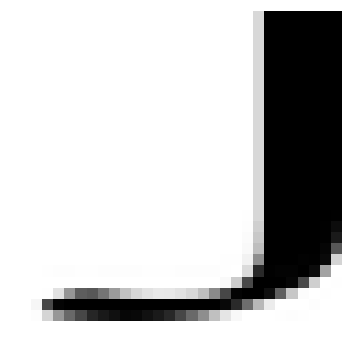

In [5]:
plot_image(train_dataset[7])

In [6]:
train_labels[7]

9

# CNN with max-pool

In [7]:
kernel_size = 5
depth = 16
num_hidden = 64
batch_size = 50
epochs = 101

tf.reset_default_graph()

with tf.name_scope('dnn'):
    tf_dataset = tf.placeholder(tf.float32, shape = (None, image_width, image_width, num_channels))
    tf_labels = tf.placeholder(tf.int64, shape = (None))
    
    layer1_weights = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_biases = tf.Variable(tf.zeros([depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal([image_width // 4 * image_height //4 * depth, num_hidden], 
                                                     stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    
    conv = tf.nn.conv2d(tf_dataset, layer1_weights, strides = [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [-1, shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    logits = tf.matmul(hidden, layer4_weights) + layer4_biases
    pass

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = tf_labels, logits=logits)
    loss = tf.reduce_mean(xentropy)
    loss_summary = tf.summary.scalar('log_loss', loss)
    pass
    
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
    training_op = optimizer.minimize(loss)
    pass

with tf.name_scope('eval'):
    predicted = tf.nn.in_top_k(logits, tf_labels, 1)
    accuracy = tf.reduce_mean(tf.cast(predicted, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)
    pass

In [8]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
file_writer = tf.summary.FileWriter('/tmp/notmnist/notmnist_dnn-CNN-maxpool', tf.get_default_graph())

# Train the model

In [9]:
with tf.Session() as sess:
    init.run()

    for epoch in range(epochs):
        for iteration in range(train_dataset.shape[0] // epochs):
            batch_index = np.random.choice(train_labels.shape[0], batch_size)
            batch_data, batch_labels = train_dataset[batch_index], train_labels[batch_index]
            feed_dict = {tf_dataset: batch_data, tf_labels: batch_labels}
            _, accuracy_val, loss_val = sess.run([training_op, accuracy, loss], feed_dict=feed_dict)
        
        test_acc_val = sess.run(accuracy, feed_dict = {tf_dataset: test_dataset, tf_labels: test_labels})
        valid_acc_val, valid_loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], 
                        feed_dict = {tf_dataset: valid_dataset, tf_labels: valid_labels})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        
        
        if epoch % 5 == 0:
            print ('Mini Batch Iteration %d, Train Loss: %.3f, Train Accuracy: %.3f' % (epoch, loss_val, accuracy_val))
            print ('Test Accuracy: %.3f, Validation Accuracy: %.3f' % (test_acc_val, valid_acc_val))
            print ('\n')
            
    save_path = saver.save(sess, "./model8.ckpt")
    pass

Mini Batch Iteration 0, Train Loss: 0.506, Train Accuracy: 0.860
Test Accuracy: 0.916, Validation Accuracy: 0.852


Mini Batch Iteration 5, Train Loss: 0.123, Train Accuracy: 0.960
Test Accuracy: 0.949, Validation Accuracy: 0.893


Mini Batch Iteration 10, Train Loss: 0.083, Train Accuracy: 1.000
Test Accuracy: 0.953, Validation Accuracy: 0.901


Mini Batch Iteration 15, Train Loss: 0.139, Train Accuracy: 0.940
Test Accuracy: 0.956, Validation Accuracy: 0.904


Mini Batch Iteration 20, Train Loss: 0.373, Train Accuracy: 0.920
Test Accuracy: 0.956, Validation Accuracy: 0.904


Mini Batch Iteration 25, Train Loss: 0.251, Train Accuracy: 0.920
Test Accuracy: 0.957, Validation Accuracy: 0.907


Mini Batch Iteration 30, Train Loss: 0.219, Train Accuracy: 0.920
Test Accuracy: 0.957, Validation Accuracy: 0.908


Mini Batch Iteration 35, Train Loss: 0.165, Train Accuracy: 0.960
Test Accuracy: 0.957, Validation Accuracy: 0.906


Mini Batch Iteration 40, Train Loss: 0.116, Train Accuracy: 0.980
